In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../utilities')
from basic_utilities import *
from model_utilities import *
from pandas.plotting import scatter_matrix
from ml_utilities import *
import scipy.stats as stats
import pdb
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pickle
sys.path.append('../Data_prep')
from data_config import *
sys.path.append('../../../../infrastructure/tools')
from utilities import utilities
import pdb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap

In [3]:
xgb_train_data = pd.read_csv(f'{intermediate_data_path}/training.csv')

In [4]:
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
for col in categorical_cols:
    xgb_train_data[col] = xgb_train_data[col].astype('category')

In [5]:
# xgb_train_data = xgb_train_data.fillna('missing')

In [6]:
xgb_train_data_seg0 = xgb_train_data.loc[xgb_train_data['segment']==0]

In [7]:
model = XGBClassifier(n_estimators=100, random_state=42, enable_categorical=True)

In [8]:
params = {
        'min_child_weight': [15, 50, 100],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1, 0.2]
        }

In [9]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [10]:
columns = xgb_train_data_seg0.columns.tolist()
columns.remove('fraud_bool')
columns.remove('sample_weight')
columns.remove('segment')

In [11]:
sample_weight=xgb_train_data_seg0['sample_weight']
X = xgb_train_data_seg0[columns]
y = xgb_train_data_seg0['fraud_bool']

In [12]:
GridSearch = GridSearchCV(model, param_grid=params, scoring='roc_auc', n_jobs=-1, 
                                   cv=skf.split(X,y), verbose=1)

In [13]:
start_time = time.time()
grid_search = GridSearch.fit(X, y, sample_weight=sample_weight)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Elapsed time: 86.67324209213257 seconds


In [14]:
best_model = grid_search.best_estimator_

In [15]:
y_pred = best_model.predict(X)

In [48]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

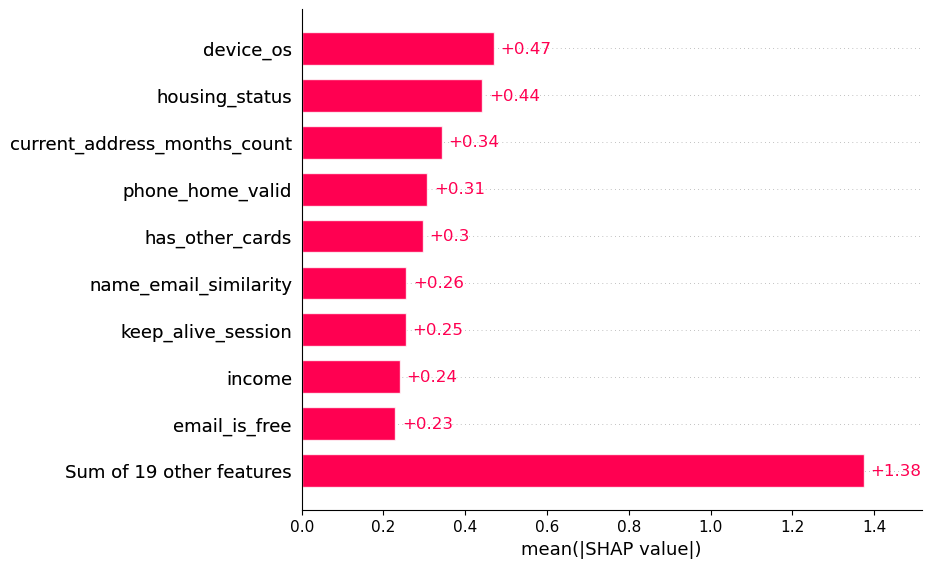

In [53]:
shap.plots.bar(shap_values)

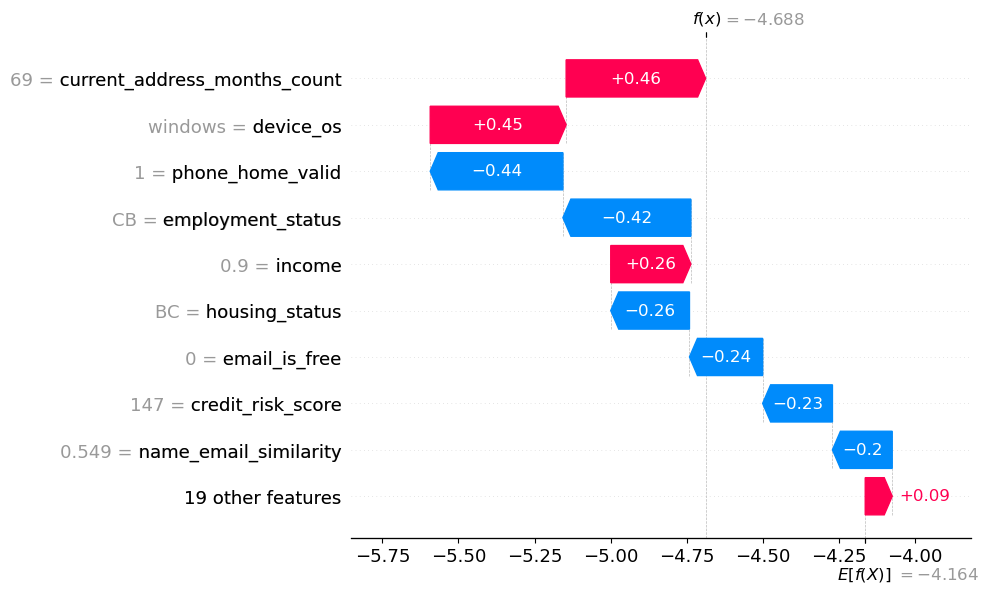

In [49]:
shap.plots.waterfall(shap_values[0])